In [118]:
# pip install -q "tensorflow==2.11.*"
# # tensorflow_io 0.28 is compatible with TensorFlow 2.11
# pip install -q "tensorflow_io==0.28.*"

# Import Libraries

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
import splitfolders

In [120]:
print(tf.__version__)

2.10.1


# Load Data

In [121]:
root_dir = 'test_data_wav_splitted'
subfolders = ['belly_pain', 'burping', 'discomfort', 'hungry', 'non_infant_cry','tired']

In [122]:
# input_folder = 'rockpaperscissors'
# output_folder = 'data'

# splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.8, 0.2))

In [123]:
file_paths = []
labels = []

# Function to collect file paths and labels from a given directory
def collect_files_and_labels(base_dir, subfolders, file_paths, labels):
    for folder_name in subfolders:
        folder_path = os.path.join(base_dir, folder_name)
        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                if file_name.endswith('.wav'):
                    file_path = os.path.join(folder_path, file_name)
                    file_paths.append(file_path)
                    labels.append(folder_name)  # Use the folder name as the label

In [124]:
# Collect .wav files and labels from the train subdirectories
train_dir = os.path.join(root_dir, 'train')
collect_files_and_labels(train_dir, subfolders, file_paths, labels)

# Collect .wav files and labels from the val subdirectories
val_dir = os.path.join(root_dir, 'val')
collect_files_and_labels(val_dir, subfolders, file_paths, labels)

In [125]:
df = pd.DataFrame({
    'File Path': file_paths,
    'Label': labels
})

In [126]:
df.head()

,File Path,Label
0,test_data_wav_splitted\train\belly_pain\643D64...,belly_pain
1,test_data_wav_splitted\train\belly_pain\643D64...,belly_pain
2,test_data_wav_splitted\train\belly_pain\643D64...,belly_pain
3,test_data_wav_splitted\train\belly_pain\643D64...,belly_pain
4,test_data_wav_splitted\train\belly_pain\643D64...,belly_pain


In [127]:
print(df['Label'].unique())

['belly_pain' 'burping' 'discomfort' 'hungry' 'non_infant_cry' 'tired']


In [128]:
# Map class names to integer labels
label_to_int = {class_name: idx for idx, class_name in enumerate(subfolders)}
df['Label'] = df['Label'].map(label_to_int)

<Axes: ylabel='count'>

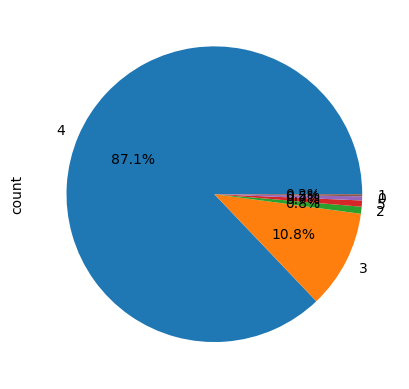

In [129]:
df['Label'].value_counts().plot(kind='pie', autopct='%.1f%%')

# Load Model

In [130]:
yamnet_url= 'https://tfhub.dev/google/yamnet/1'
yamnet = hub.load(yamnet_url)

# Pre Process Data

In [131]:
X = df['File Path']
y = df['Label']

In [132]:
def train_validate_test_split(df):
    df = df.sample(frac=1).reset_index(drop=True)
    train_end = int(.9 * len(df.index))
    validate_end = int(.05 * len(df.index)) + train_end
    train = df.iloc[:train_end]
    validate = df.iloc[train_end:validate_end]
    test = df.iloc[validate_end:]
    return train, validate, test

In [133]:
# Split the DataFrame into training, validation, and test sets
df_train, df_validation, df_test = train_validate_test_split(df)

# Print the lengths of the splits
print(len(df_train), len(df_validation), len(df_test))

3191 177 178


In [134]:
train_ds = tf.data.Dataset.from_tensor_slices((df_train['File Path'], df_train['Label']))
valid_ds = tf.data.Dataset.from_tensor_slices((df_validation['File Path'], df_validation['Label']))
test_ds = tf.data.Dataset.from_tensor_slices((df_test['File Path'], df_test['Label']))

In [135]:
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [136]:
def wav_map(file_path, label):
    return load_wav_16k_mono(file_path), label

In [137]:
def extract_yamnet_embeddings(wav_data, targets):
    scores, embeddings, spectrogram = yamnet(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings, tf.repeat(targets, num_embeddings))

In [139]:
def process_dataset(dataset):
    return (
        dataset
        .map(wav_map)
        .map(extract_yamnet_embeddings)
        .unbatch()
        .cache()
        .shuffle(1000)
        .batch(32)
        .prefetch(tf.data.AUTOTUNE)
    )

train_ds = process_dataset(train_ds)
valid_ds = process_dataset(valid_ds)
test_ds = process_dataset(test_ds)

NotImplementedError: in user code:

    File "C:\Users\wikab\AppData\Local\Temp\ipykernel_1424\1282256880.py", line 2, in wav_map  *
        return load_wav_16k_mono(file_path), label
    File "C:\Users\wikab\AppData\Local\Temp\ipykernel_1424\212221097.py", line 9, in load_wav_16k_mono  *
        wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    File "c:\Users\wikab\python-gpu\lib\site-packages\tensorflow_io\python\ops\audio_ops.py", line 462, in resample  **
        value = tf.vectorized_map(f, input)
    File "c:\Users\wikab\python-gpu\lib\site-packages\tensorflow_io\python\ops\audio_ops.py", line 458, in f
        return core_ops.io_audio_resample(
    File "c:\Users\wikab\python-gpu\lib\site-packages\tensorflow_io\python\ops\__init__.py", line 88, in __getattr__
        return getattr(self._load(), attrb)
    File "c:\Users\wikab\python-gpu\lib\site-packages\tensorflow_io\python\ops\__init__.py", line 84, in _load
        self._mod = _load_library(self._library)
    File "c:\Users\wikab\python-gpu\lib\site-packages\tensorflow_io\python\ops\__init__.py", line 69, in _load_library
        raise NotImplementedError(

    NotImplementedError: unable to open file: libtensorflow_io.so, from paths: ['c:\\Users\\wikab\\python-gpu\\lib\\site-packages\\tensorflow_io\\python\\ops\\libtensorflow_io.so']
    caused by: ['c:\\Users\\wikab\\python-gpu\\lib\\site-packages\\tensorflow_io\\python\\ops\\libtensorflow_io.so not found']


# Load Model

In [ ]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history = model.fit(train_ds, epochs=10, validation_data=valid_ds, callbacks=[early_stopping])

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.head()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
ax = axes.ravel()

for i, metric in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history['val_' + metric])
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel(metric)
    ax[i].set_ylim([0, 1])
    ax[i].legend(['train', 'valid'])

plt.show()

In [ ]:
results = model.evaluate(test_ds, verbose=0)
print(f'Test Loss: {results[0]}')
print(f'Test Accuracy: {results[1]}')